# ToyBrain data: Generate data, visualize distributions, and create baselines 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import datasets, linear_model
from tqdm.notebook import tqdm
import random
import math
import json

from create_toybrains import ToyBrainsData
from helper.viz_helpers import *

## Generate data

### Check the settings

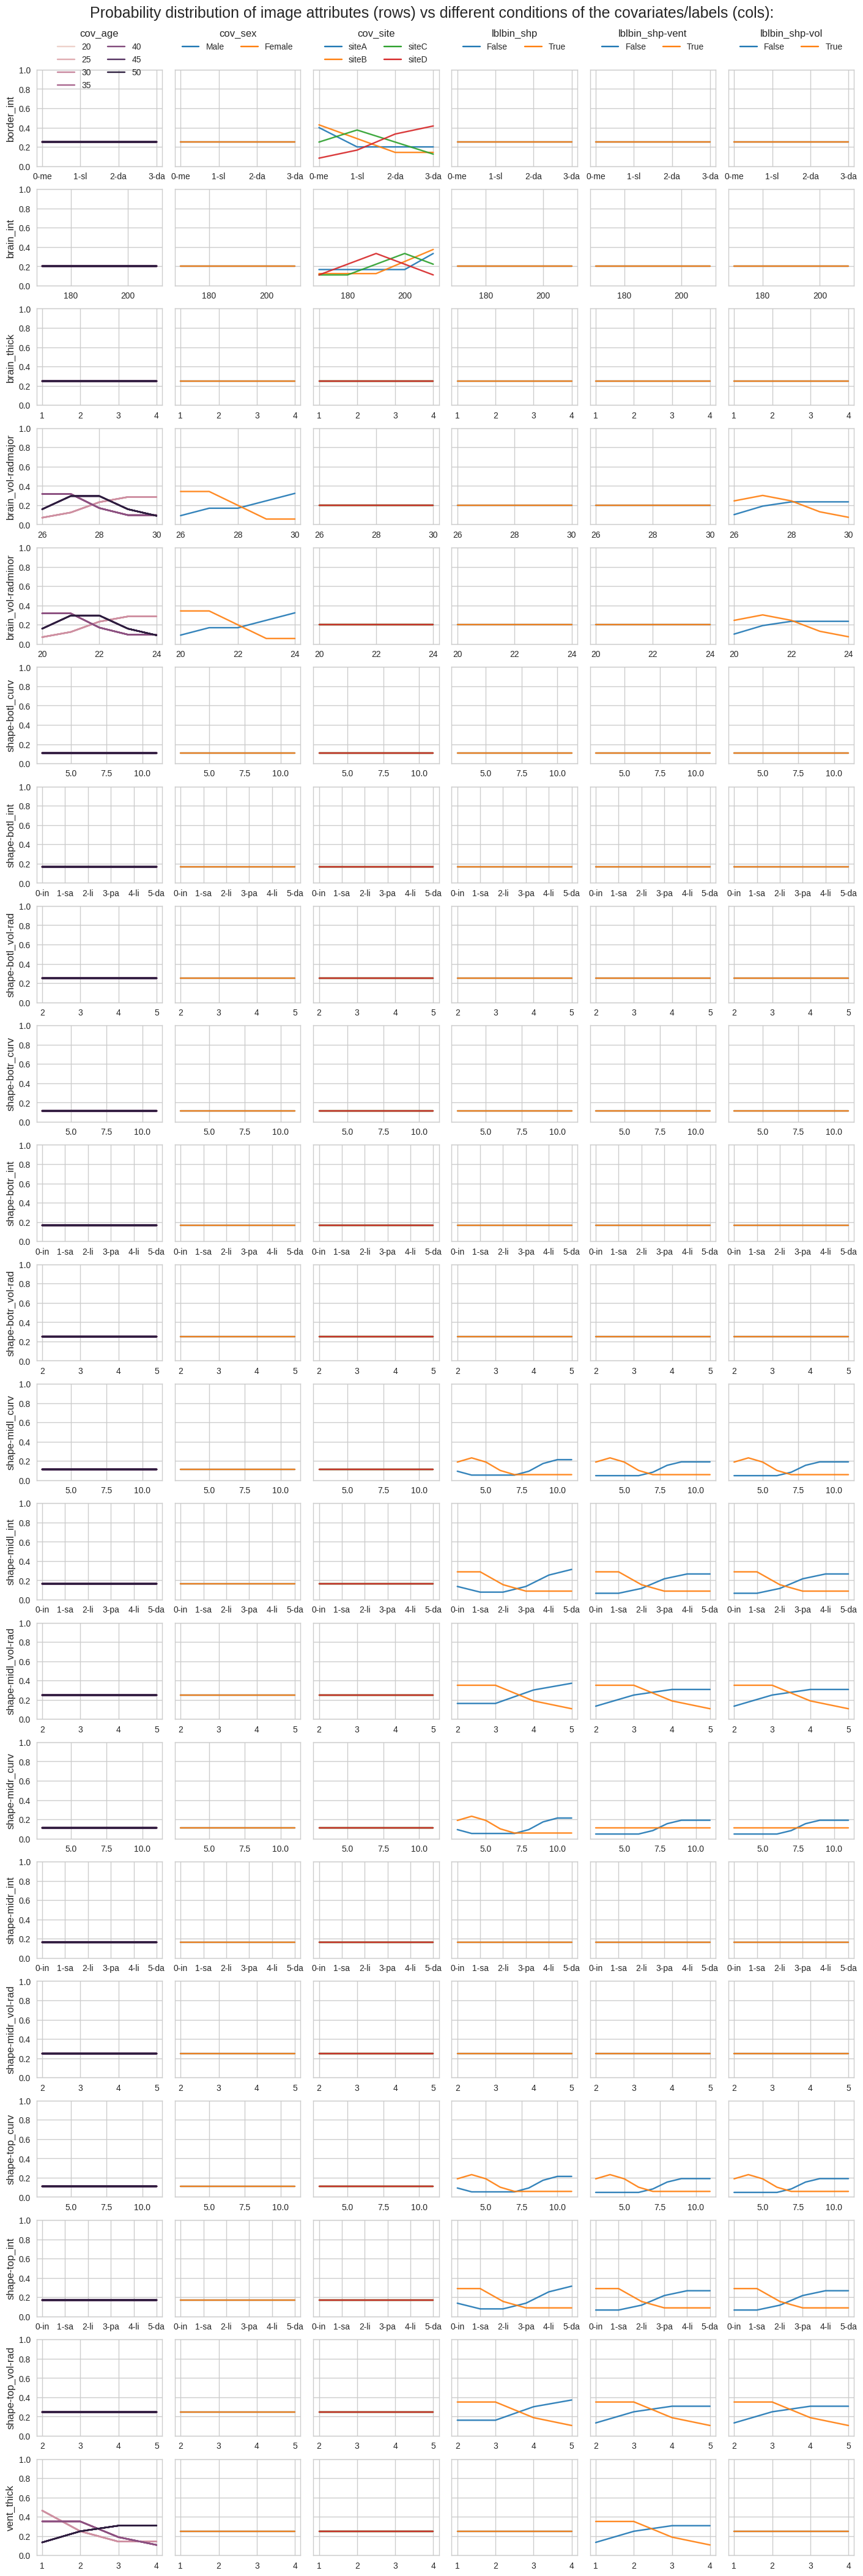

In [89]:
ToyBrainsData().show_current_config()

### Generate data 

In [45]:
# turn on the debug switch
! python create_toybrains.py -d -n 100

Generative parameter        |        States 
------------------------------------------------------------
brain_vol-radminor         [20 21 22 23 24]
brain_vol-radmajor         [26 27 28 29 30]
brain_thick                [1 2 3 4]
brain_int                  [210 200 190 180 170]
border_int                 ['0-mediumslateblue' '1-slateblue' '2-darkslateblue' '3-darkblue']
vent_thick                 [1 2 3 4]
shape-top_curv             [ 3  4  5  6  7  8  9 10 11]
shape-top_int              ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkgreen']
shape-top_vol-rad          [2 3 4 5]
shape-midr_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midr_int             ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkgreen']
shape-midr_vol-rad         [2 3 4 5]
shape-midl_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midl_int             ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkg

## Visualize generated data

In [57]:
DATA_DIR = "toybrains30k" #"toybrains10k"
df = pd.read_csv(glob(f"{DATA_DIR}/toybrains_n*.csv")[0]).set_index('subjectID')

In [58]:
# sort dataframe cols by column name
df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _gen_brain_vol-radmajor  30000 non-null  float64
 1   _gen_brain_vol-radminor  30000 non-null  float64
 2   _gen_shape-botl_vol-rad  30000 non-null  float64
 3   _gen_shape-botr_vol-rad  30000 non-null  float64
 4   _gen_shape-midl_vol-rad  30000 non-null  float64
 5   _gen_shape-midr_vol-rad  30000 non-null  float64
 6   _gen_shape-top_vol-rad   30000 non-null  float64
 7   cov_age                  30000 non-null  float64
 8   cov_sex                  30000 non-null  object 
 9   cov_site                 30000 non-null  object 
 10  gen_border_int           30000 non-null  object 
 11  gen_brain_int            30000 non-null  float64
 12  gen_brain_thick          30000 non-null  float64
 13  gen_brain_vol            30000 non-null  float64
 14  gen_shape-botl_curv   

### (1) 2D Images

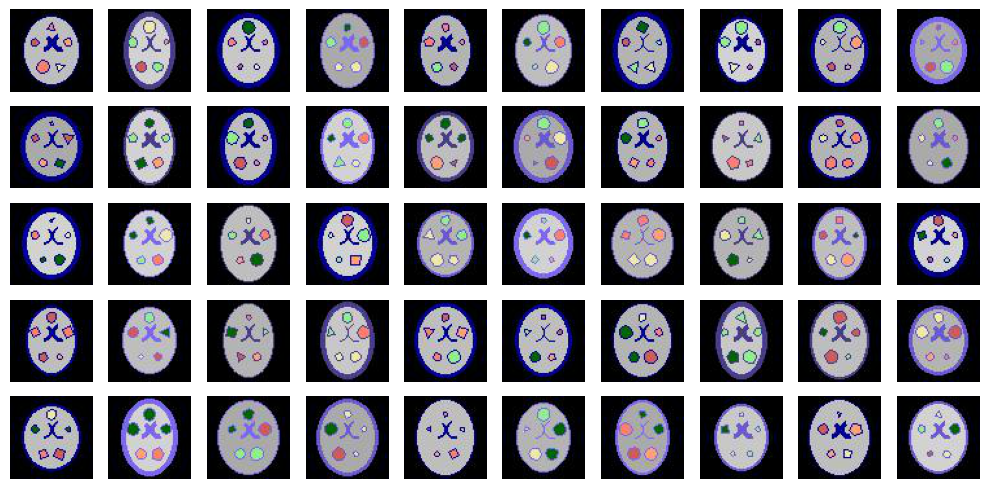

In [59]:
img_files = sorted(glob(f"{DATA_DIR}/images/*.jpg"))
show_images(img_files=img_files, n_rows=5)

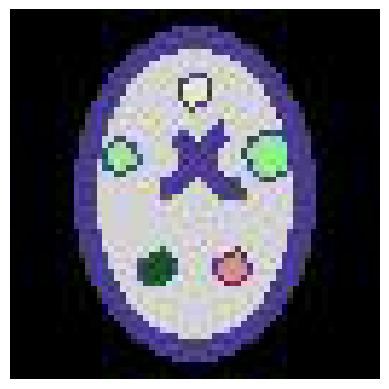

In [68]:
# one random image
img_file = np.random.choice(img_files)
img = mpimg.imread(img_file)
f = plt.figure(frameon=False)
plt.imshow(img)
plt.axis('off')
# plt.savefig("docs/brain.png", bbox_inches='tight')
plt.show()

#### (a) Image attributes

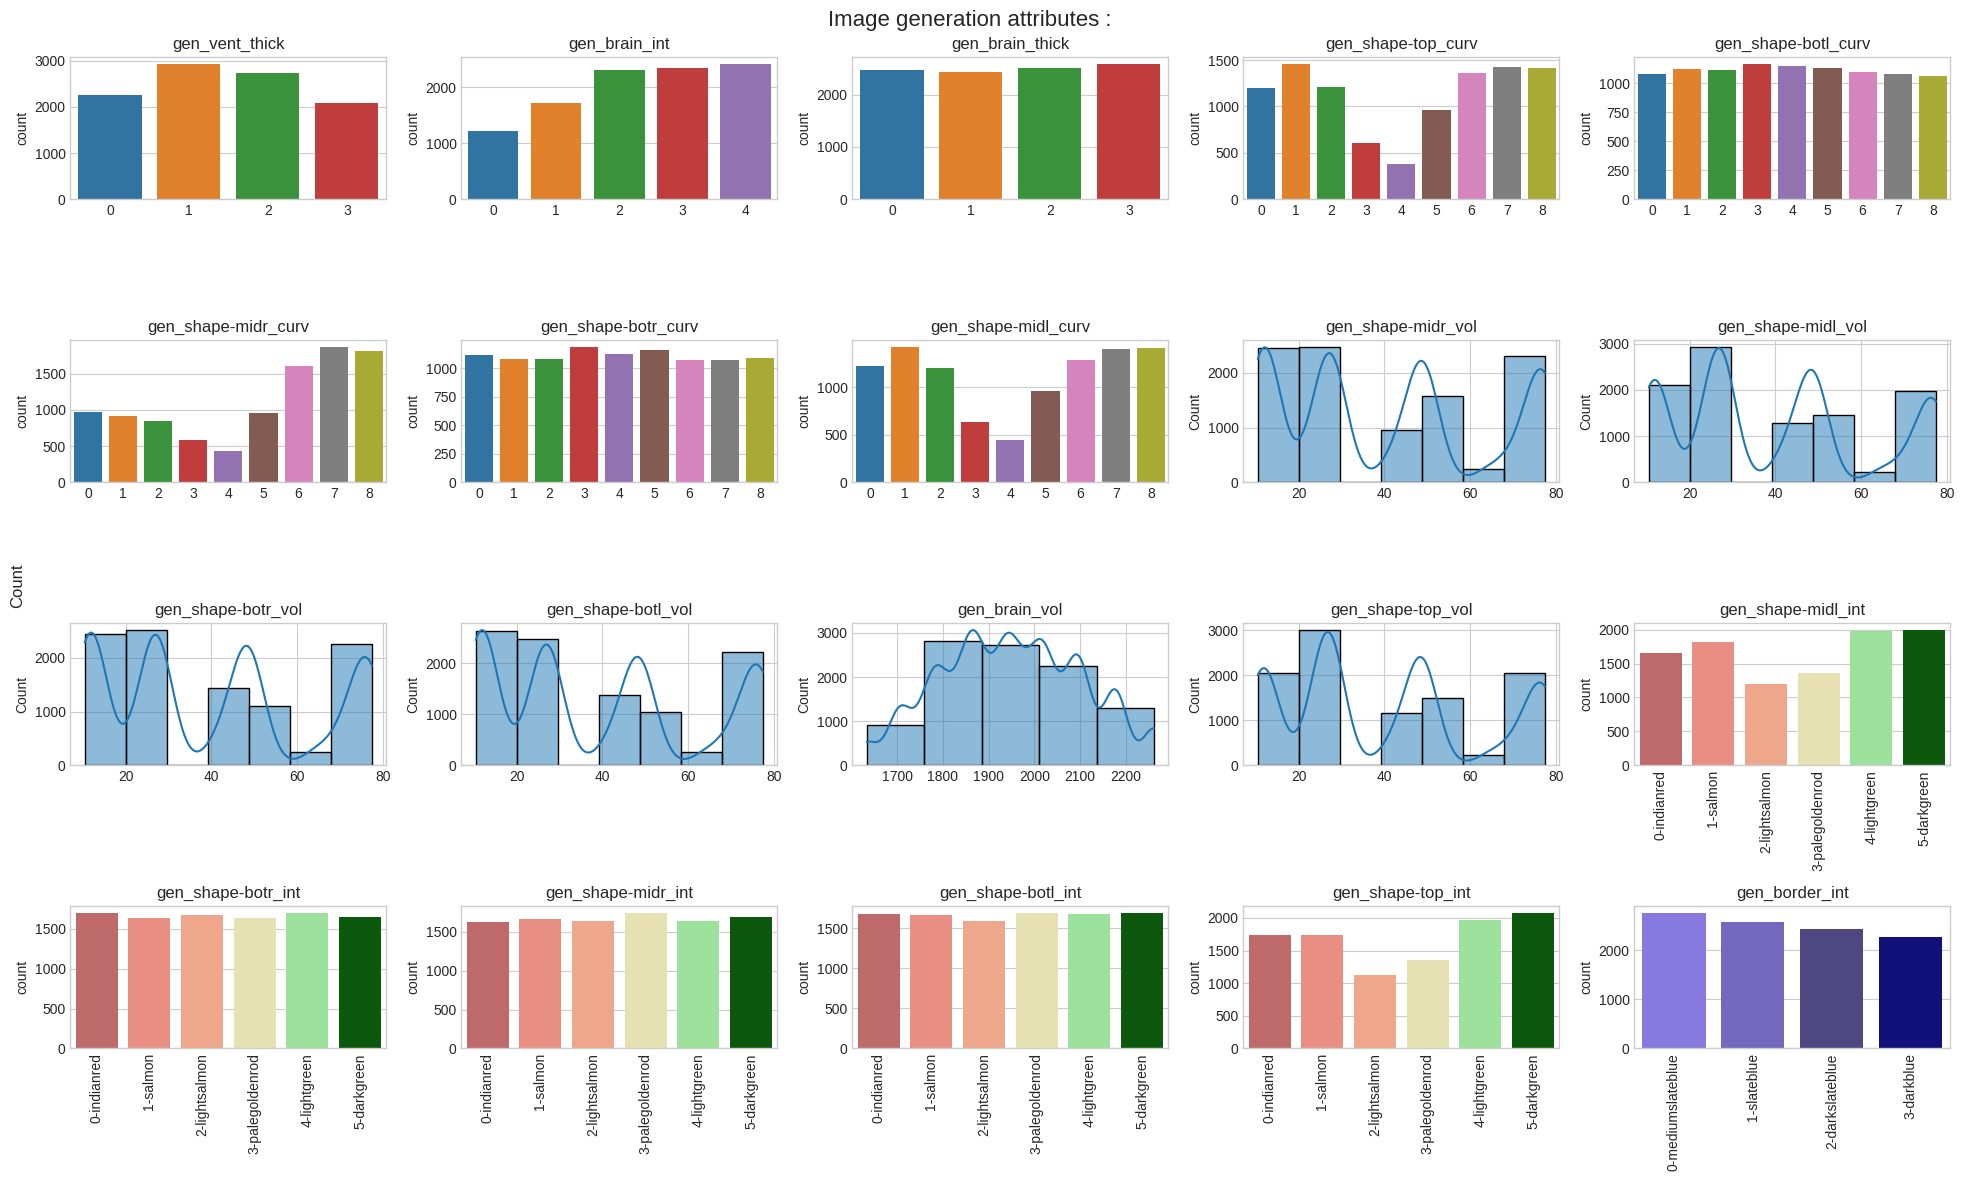

In [40]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^gen_'), title="Image generation attributes :")
plt.show()

### (2) Labels

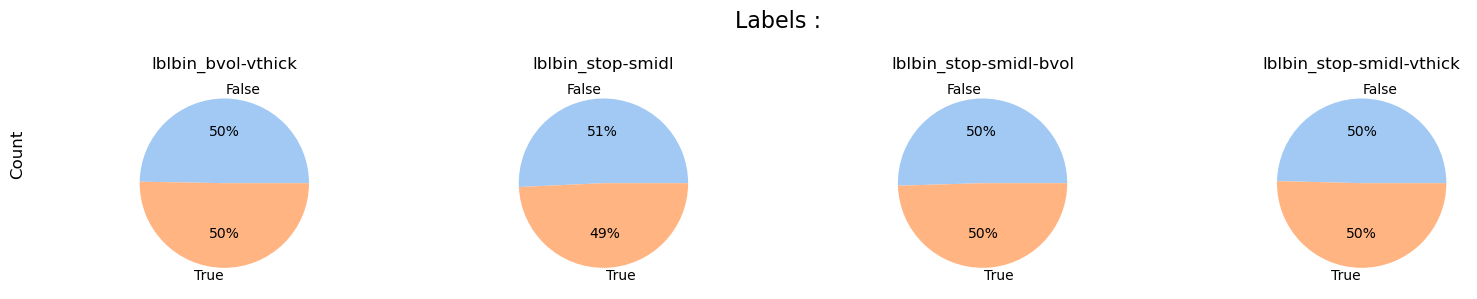

In [15]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^lbl'), title="Labels :")
plt.show()

### (3) Covariates distribution

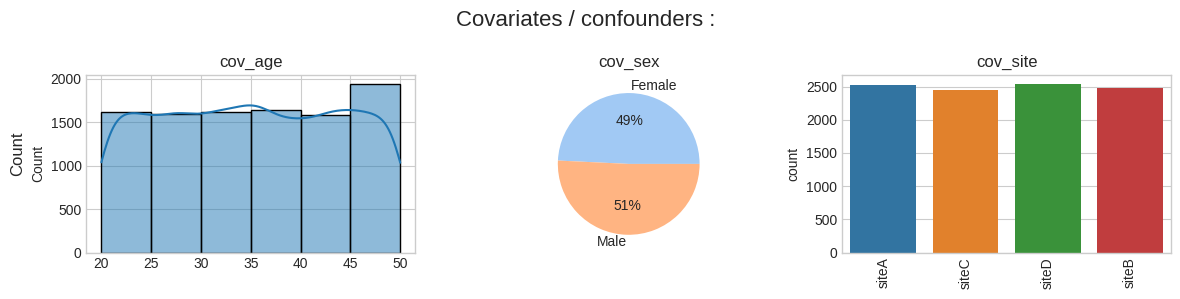

In [39]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^cov_'), title="Covariates / confounders :")
plt.show()

### (4) Image attributes vs Covariates & Labels

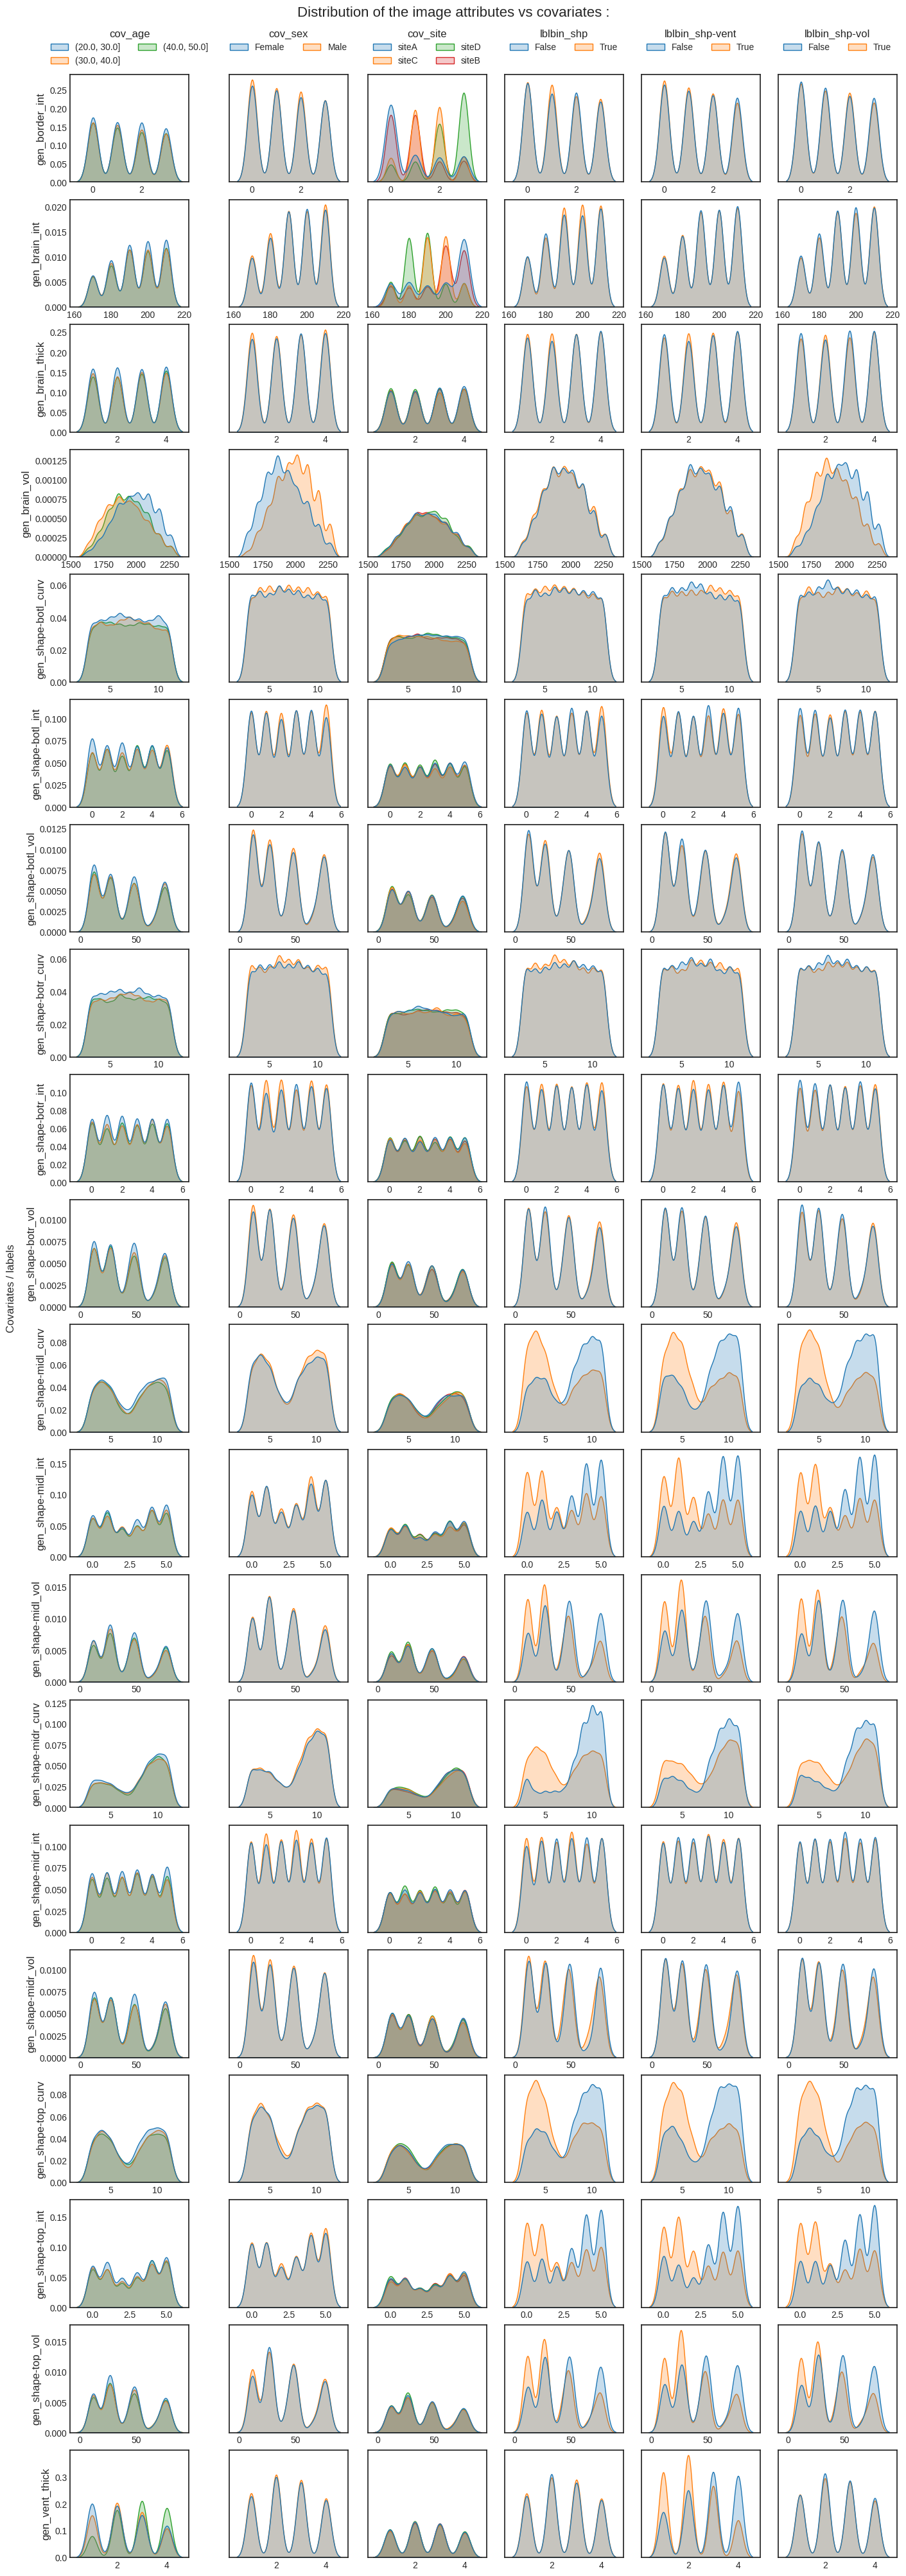

In [51]:
# get all column names starting with 'gen_'
plot_col_dists(df, attr_cols=df.filter(regex='^gen_').columns, cov_cols=df.filter(regex='^(cov_|lbl)').columns, 
               title="Distribution of the image attributes vs covariates :")
plt.show()

## Baseline predictive models

## TODOS:

#### Generate CausalGraphicalModels

In [44]:
# from causalgraphicalmodels import CausalGraphicalModel


# sprinkler = CausalGraphicalModel(
#     nodes=["season", "rain", "sprinkler", "wet", "slippery"],
#     edges=[
#         ("season", "rain"), 
#         ("season", "sprinkler"), 
#         ("rain", "wet"),
#         ("sprinkler", "wet"), 
#         ("wet", "slippery")
#     ]
# )

# # draw return a graphviz `dot` object, which jupyter can render
# sprinkler.draw()

In [ ]:
## Create the ventricles image

# from PIL import Image, ImageDraw
# S=200
# # Create a new image with a black background
# img = Image.new("RGB", (S, S), color="black")

# # Draw two arcs at the center of the image, facing opposite to each other and touching at the center
# draw = ImageDraw.Draw(img)
# x_off, y_off= 0,0
# xy_r = (S*.2, S*.2, S*.5, S*.5)
# xy_l = (S*.5, S*.2, S*.8, S*.5)
# print(xy_r, xy_l)
# draw.arc(xy_r, start=300, end=100,   fill="red",  width=8)
# draw.arc(xy_l, start=-300, end=-100, fill="blue", width=8)

# # Show the image
# img

## Misl / ReadMe figures

##### Image attributes plot for the ReadMe

In [23]:
# plt.rcParams['axes.facecolor']='black'
# plt.rcParams['savefig.facecolor']='black'
# fs = 12
# atrs = sorted([col for col in df.filter(regex='^gen_').columns if 'shape' not in col])
# # drop all shapes except one to show
# atrs_shape = [col for col in df.filter(regex='^gen_').columns if ('botr' in col)]
# atrs = atrs + atrs_shape
# # f, axes = plt.subplots(len(atrs), 1, figsize=(7,1.3*len(atrs)), constrained_layout=True)
# f = plt.figure(constrained_layout=True, figsize=(7,1.3*len(atrs)))
# f.suptitle(f"Modifying different image attributes:", 
#            fontsize=fs+2, ha='right', x=0.1, fontweight='heavy')
# # define each subplots row as a subfigure and set separate subtitles
# subfigs = f.subfigures(len(atrs), 1)

# for i, subfig in enumerate(subfigs):
    
#     atr = atrs[i]
#     atr_vals = df[atr].sort_values().unique()
#     if len(atr_vals)>7: # if more than 7 then sample the least best and some values in between
#         atr_vals = [atr_vals[0]] + np.sort(np.random.choice(atr_vals[1:-2], 7-2)).tolist() + [atr_vals[-1]]
#     # print(atr)
#     # color = 'darkred' if 'brain' in atr else ('darkgreen' if 'shape' in atr else 'darkblue')
#     subfig.suptitle(atr.replace('gen_',''), 
#                     fontsize=fs, color='r', ha='right', x=0.12, fontweight='heavy')
#     axes_row = subfig.subplots(nrows=1, ncols=7)
    
#     # organize the attribute sorting order so that  the images are similar to each other within each row
#     col_order = atrs[:]
#     related_atrs = [col for col in col_order if (atr.split('_')[1] in col) and (col!=atr)]
#     col_order = [atr] + related_atrs + [c for c in col_order if c not in (related_atrs + [atrs])]
#     df_sorted = df.sort_values(by=col_order, axis=0)
    
#     for j, ax in enumerate(axes_row):
#         if j<len(atr_vals):
#             atr_val = atr_vals[j]
#             sample = df_sorted.loc[df_sorted[atr]==atr_val].iloc[0]
#             subID = f"{sample.name:05}"
#             # print(subID) 
#             img = mpimg.imread(f"toybrains/images/{subID}.jpg")
#             ax.imshow(img)
#             if isinstance(atr_val, float): atr_val = int(atr_val)
#             if isinstance(atr_val, str): atr_val = atr_val.split('-')[1]
#             ax.set_title(f"= {atr_val}", fontsize=fs-4, ha='center')
        
#         ax.axis("off")

# # plt.savefig("docs/image_attrs.png", bbox_inches='tight')
# plt.show()

In [50]:
# plt.rcParams['axes.facecolor']='black'
# plt.rcParams['savefig.facecolor']='black'
# fs = 12

# atrs = sorted([col for col in df.filter(regex='^cov_').columns])
# # f, axes = plt.subplots(len(atrs), 1, figsize=(7,1.3*len(atrs)), constrained_layout=True)
# f = plt.figure(constrained_layout=True, figsize=(7,1.3*len(atrs)))
# # f.suptitle(f"Modifying different image attributes:", 
# #            fontsize=fs+2, ha='right', x=0.1, fontweight='heavy')
# # define each subplots row as a subfigure and set separate subtitles
# subfigs = f.subfigures(len(atrs), 1)

# for i, subfig in enumerate(subfigs):
    
#     atr = atrs[i]
#     atr_vals = df[atr].sort_values().unique()
#     if len(atr_vals)>7: # if more than 7 then sample the least best and some values in between
#         atr_vals = [atr_vals[0]] + np.sort(np.random.choice(atr_vals[1:-2], 7-2)).tolist() + [atr_vals[-1]]
#     # print(atr)
#     # color = 'darkred' if 'brain' in atr else ('darkgreen' if 'shape' in atr else 'darkblue')
#     subfig.suptitle(atr.replace('gen_',''), 
#                     fontsize=fs, color='blue', ha='right', x=0.12, fontweight='heavy')
#     axes_row = subfig.subplots(nrows=1, ncols=7)
    
#     # organize the attribute sorting order so that  the images are similar to each other within each row
#     col_order = atrs[:]
#     related_atrs = [col for col in col_order if (atr.split('_')[1] in col) and (col!=atr)]
#     col_order = [atr] + related_atrs + [c for c in col_order if c not in (related_atrs + [atrs])]
#     df_sorted = df.sort_values(by=col_order, axis=0)
    
#     for j, ax in enumerate(axes_row):
#         if j<len(atr_vals):
#             atr_val = atr_vals[j]
#             sample = df_sorted.loc[df_sorted[atr]==atr_val].iloc[0]
#             subID = f"{sample.name:05}"
#             # print(subID) 
#             img = mpimg.imread(f"toybrains/images/{subID}.jpg")
#             ax.imshow(img)
#             if isinstance(atr_val, float): atr_val = int(atr_val)
#             if isinstance(atr_val, str): atr_val = atr_val.split('-')[1]
#             ax.set_title(f"= {atr_val}", fontsize=fs-4, ha='center')
        
#         ax.axis("off")

# # plt.savefig("docs/image_attrs.png", bbox_inches='tight')
# plt.show()